# Visual transformer for mixed-type wafer defect pattern recognition
- This notebook is belong to https://github.com/PanithanS/Visual-Transformer-Mixed-type-Wafers-Defect-Recognition

In [2]:
#pip install -U tensorflow-addons

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, clear_output, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

In [3]:
class data_loader:
    
    def __init__(self, dataset_path, vis=False):
        
        """this funtion is to initialize the data_loader class
        
        Args:
            dataset_path(string): the dataset object address
        
        """
        
        self.dataset_path = dataset_path
        self.is_vis = vis
        
        # The list that use to translate the label to defects type
        self.label_keys = ["Center, ", "Donut, ", "Edge_Loc, ", "Edge_Ring, ", 
                           "Loc, ", "Near_Full, ", "Scratch, ", "Random, "]

    def load_data(self):
        
        """this funtion is to load data to the vaiable "self.train" and "self.label"  """
        
        self.data = np.load(self.dataset_path)
        self.train = self.data["arr_0"]
        self.label = self.data["arr_1"]
        
        #print("data_x",np.shape(self.train))
        print("MixedWM38:", np.shape(self.label)[0], 'wafer loaded')
        
    def prep_data(self):
        
        """this funtion is to do train_test_split and format the data"""
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.train, self.label, test_size = 0.2)
        
        # Make sure images have shape (Batch, image_size, image_size, channel)
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test, -1)
        
        # Convert class vectors to right format
        self.y_train = tf.convert_to_tensor(np.array(self.y_train))
        self.y_test = tf.convert_to_tensor(np.array(self.y_test))
    
    def read_label(self, label, defect_types =''):
        
        """this funtion is to translate the label into defect_types
        
        Args:
            label(list): the label that indicate type of  defect, for instance [0 1 0 1 0 0 0 1]

        Return:
            defect_types(string): the string that indicate defect type
        """
       
        if np.sum(label) == 0:
            defect_types = 'Normal wafer'
        
        else:
            for digit in range(np.shape(label)[0]):

                if label[digit] == 1:

                    defect_types = defect_types + self.label_keys[digit]  
        
        return defect_types
    
    def see_wafer(self, wafer_num):
        
        """this funtion is to see the defect pattern in idicated by wafer number
        
        
        Args:
            wafer_num(float): the index of loaded data in self.train

        Return:
            plot(oject): the plot image
        """
        
        defect_types = self.read_label(self.label[wafer_num])
        
        plt.title("wafer #"+str(wafer_num))
        plt.imshow(self.train[wafer_num])
        plt.colorbar()
        plt.show()
        
        print("Defect types=", defect_types)
        print("Labeled as:", self.label[wafer_num])
        
    def get_data(self):
        
        """this funtion is get the loaded data 

        Return:
            x_train(array): image of defect pattern for model training
            x_test(array): image of defect pattern for model validation
            y_train(tensor): label of defect pattern for model training
            y_test(tensor): label of defect pattern for model validation
        """
            
        self.load_data()
        self.prep_data()
        
        return self.x_train, self.x_test, self.y_train, self.y_test

In [4]:
dataset_path = r'C:\Users\admin\Desktop\PanithanS\Wafer_defect\Wafer_Map_Datasets.npz'

A1 = data_loader(dataset_path, vis=True)
x_train, x_test, y_train, y_test = A1.get_data()

MixedWM38: 38015 wafer loaded


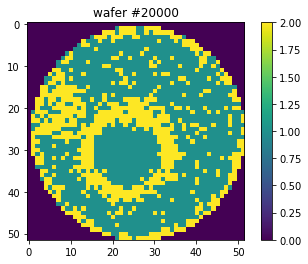

Defect types= Donut, Edge_Ring, Loc, 
Labeled as: [0 1 0 1 1 0 0 0]


In [5]:
# 2 type
A1.see_wafer(20000)

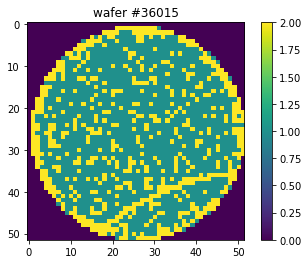

Defect types= Edge_Ring, Scratch, 
Labeled as: [0 0 0 1 0 0 1 0]


In [6]:
# 2 type
A1.see_wafer(36015)

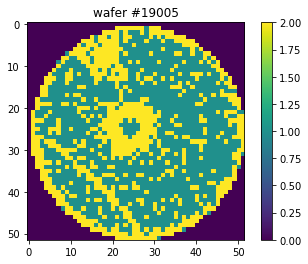

Defect types= Donut, Edge_Ring, Loc, Scratch, 
Labeled as: [0 1 0 1 1 0 1 0]


In [7]:
# 4 type
A1.see_wafer(19005)

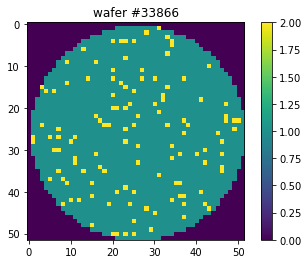

Defect types= Normal wafer
Labeled as: [0 0 0 0 0 0 0 0]


In [8]:
# Normal
A1.see_wafer(33866)

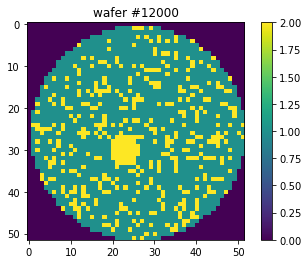

Defect types= Center, 
Labeled as: [1 0 0 0 0 0 0 0]


In [9]:
# 1 type
A1.see_wafer(12000)

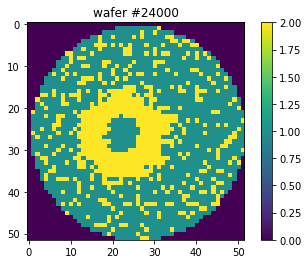

Defect types= Donut, 
Labeled as: [0 1 0 0 0 0 0 0]


In [10]:
# 1 type
A1.see_wafer(24000)

#  Visual transformer model and training

In [24]:
class vis_transformer:
     
    def __init__(self, x_train, x_test, y_train, y_test):
        
        """this funtion is to initialize the vis_transformer class
        
        Args:
            x_train(array): image of defect pattern for model training
            x_test(array): image of defect pattern for model validation
            y_train(tensor): label of defect pattern for model training
            y_test(tensor): label of defect pattern for model validation

        """
        
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        (_, self.image_size, b, c) = np.shape(self.x_train) # We'll resize input images to this size
        
        self.input_shape = (self.image_size, self.image_size, c)

        self.label_size = np.shape(y_test)[1]
        self.patch_size = 13  # Size of the patches to be extract from the input images
        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.projection_dim = 96
        self.num_heads = 4
        self.transformer_units = [self.projection_dim * 2, self.projection_dim,]  # Size of the transformer layers
        self.transformer_layers = 16
        self.mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
        
    def augmentation(self):
        
        """this funtion is as oject function to do data augmentation"""
        
        data_augmentation = keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.Normalization(),
                tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
                tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
            ], name="data_augmentation",)

        # Compute the mean and the variance of the training data for normalization.
        data_augmentation.layers[0].adapt(self.x_train)
        
        
    def mlp(self, x, hidden_units, dropout_rate):
        
        """this funtion is multilayer perceptron(mpl) head
        
        Args:
            hidden_units(list): the hidden dimenstion of the mpl
            dropout_rate(float): dropout rate of mpl

        """
        
        for units in hidden_units:

            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)

        return x

    def get_patches(self, images):
                
        """this funtion is to split image into patches of "self.patch_size" x "self.patch_size"
        
        Args:
            images(array): the images to applied patches

        Return:
            patches(array): the image patches
        
        """
            
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return patches
    
    def see_patches(self, image, num_image):
        
        patches = self.get_patches(image)
        
        image = self.x_train[num_image]
        plt.imshow(image)
        plt.clim(0,2)
        plt.axis("off")

        resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(self.image_size, self.image_size))
        
        patches = self.get_patches(resized_image)
        
        print(f"Image size: {self.image_size} X {self.image_size}")
        print(f"Patch size: {self.patch_size} X {self.patch_size}")
        print(f"Patches per image: {patches.shape[1]}")
        print(f"Elements per patch: {patches.shape[-1]}")
        print(f"Num patch:", self.num_patches)

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[0]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size))
            plt.imshow(patch_img.numpy())
            plt.clim(0,2)
            plt.axis("off")
        
        print(np.shape(patches))
        
    def get_patchencoder(self, patch):
        
        """this funtion is encode the patch as projection on dense layer with position embedding 
        
        Args:
            patch(array): the images to applied patches

        Return:
            encoded(oject): the encoded patches
        
        """
        
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(input_dim=self.num_patches, output_dim=self.projection_dim)

        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)

        return encoded
    
    def create_model(self):
        
        """this funtion is to create visual transformer
        
        Return:
            model(object): visual transformer model
        
        """
        inputs = layers.Input(shape=(52,52,1))

        # Augment data.
        images = inputs #data_augmentation(inputs)

        # Create patches.
        patches = self.get_patches(images)

        # Encode patches.
        encoded_patches = self.get_patchencoder(patches)

        #print(np.shape(encoded_patches))

        # Create multiple layers of the Transformer block.

        for _ in range(self.transformer_layers):

            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.projection_dim, dropout=0.1)(x1, x1)

            #print(np.shape(attention_output))

            # Skip connection 1.
            x2 = layers.Add()([attention_output, encoded_patches])

            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

            # MLP.
            x3 = self.mlp(x3, hidden_units=self.transformer_units, dropout_rate=0.1)

            # Skip connection 2.
            encoded_patches = layers.Add()([x3, x2])

        #print('encoded_patches:', np.shape(encoded_patches))

        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.2)(representation)

        #print('representation:', np.shape(representation))

        # Add MLP.
        features = self.mlp(representation, hidden_units=self.mlp_head_units, dropout_rate=0.5)

        #print('features:', np.shape(features))

        # Classify outputs.
        #features = layers.Dense(label_size*2, kernel_initializer='he_uniform', activation='relu')(features)
        logits = layers.Dense(self.label_size, activation='sigmoid')(features)

        # Create the Keras model.
        model = keras.Model(inputs=inputs, outputs=logits)

        #print(model.summary())

        return model
    
    
    def train_model(self, batch_size = 512, num_epochs = 40, save_path='none'):
        
        """this funtion is to train the visual transformer model
        
        Args:
            batch_size(float): training batch_size
            num_epochs(float): training num_epochs
            num_epochs(string): model oject address, and it will be use for history saving file too
        
        Return:
            history(dict): training history
        
        """
        self.model_vit = self.create_model()
        
        if save_path != 'none':
            print("set model-saving: " + save_path )
            print("set history-saving: " + save_path+'_history' )
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
        opt = tf.keras.optimizers.Adam(lr_schedule)

        self.model_vit.compile(optimizer=opt, loss='binary_crossentropy',metrics=keras.metrics.BinaryAccuracy(name="accuracy"))

        checkpoint_filepath = "./tmp/checkpoint"
        checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )

        history = self.model_vit.fit(
            x=self.x_train,
            y=self.y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_split=0.1,
            callbacks=[checkpoint_callback],
        )

        self.model_vit.load_weights(checkpoint_filepath)
        _, accuracy = self.model_vit.evaluate(self.x_test, self.y_test)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")
        
        if save_path!= 'none':
            self.model_vit.save_weights(save_path)
            
            with open(save_path+'_history', 'wb') as file_pi:
                pickle.dump(history.history, file_pi)
        
        return history
    
    def load_model(self, path, plot=False):
        
        """this funtion is to load the training weight of the visual transformer model
        
        Args:
            path(string): model oject address, and it will be use for history loading file too
        
        Return:
            self.model_vit(oject): the visual transformer model with loaded weight
        
        """
            
        try:
            del self.model_vit
        except:
            print("load model")
        
        self.model_vit = self.create_model()
        self.model_vit.load_weights(path)
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
        opt = tf.keras.optimizers.Adam(lr_schedule)

        self.model_vit.compile(optimizer=opt, loss='binary_crossentropy',metrics=keras.metrics.BinaryAccuracy(name="accuracy"))
        
        with open(path+'_history', "rb") as file_pi:
            history = pickle.load(file_pi)
        
        if (plot):
            # Plot training and validation loss
            plt.figure(dpi=100)  # You can adjust the figure size if needed
            
            plt.plot(history['val_accuracy'], label='Validation accuracy')
            plt.plot(history['accuracy'], label='Training accuracy')
            
            plt.plot(history['val_loss'], label='Validation loss')
            plt.plot(history['loss'], label='Training Loss')
            
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.show()

        return self.model_vit
    
    def model_eval(self, model, x_test, y_test):
        
        """this funtion is for model accuracy checking"""
        
        loss, accuracy = model.evaluate(x_test, y_test)
        
        print("loss: ", loss, "accuracy: ", accuracy )
        print(f"Test accuracy: {round(accuracy*100, 2)}%")

###  Briefly check on the patches

Image size: 52 X 52
Patch size: 13 X 13
Patches per image: 16
Elements per patch: 169
Num patch: 16
(1, 16, 169)


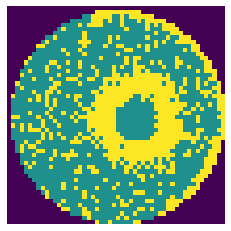

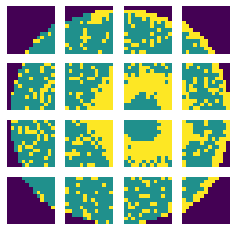

In [33]:
A_test_patches = vis_transformer(x_train, x_test, y_train, y_test)
A_test_patches.see_patches(x_test, num_image=250)

### ViT intitialize to train a new model or create the model for weight loading

In [6]:
A2 = vis_transformer(x_train, x_test, y_train, y_test)

# model weight file to be loaded
path = r"C:\Users\admin\Desktop\PanithanS\Wafer_defect\model_vit_v1b"

# If train new model
history = A2.train_model(batch_size = 512, num_epochs = 45, save_path=path)

set model-saving: C:\Users\admin\Desktop\PanithanS\Wafer_defect\model_vit_v1b
set history-saving: C:\Users\admin\Desktop\PanithanS\Wafer_defect\model_vit_v1b_history
Epoch 1/45
54/54 [==============================] - 293s 5s/step - loss: 0.6839 - accuracy: 0.6611 - val_loss: 0.5090 - val_accuracy: 0.7012
Epoch 2/45
54/54 [==============================] - 307s 6s/step - loss: 0.5495 - accuracy: 0.7035 - val_loss: 0.5124 - val_accuracy: 0.7105
Epoch 3/45
54/54 [==============================] - 322s 6s/step - loss: 0.5125 - accuracy: 0.7079 - val_loss: 0.5017 - val_accuracy: 0.7105
Epoch 4/45
54/54 [==============================] - 330s 6s/step - loss: 0.5036 - accuracy: 0.7099 - val_loss: 0.4933 - val_accuracy: 0.7388
Epoch 5/45
54/54 [==============================] - 319s 6s/step - loss: 0.4717 - accuracy: 0.7291 - val_loss: 0.3476 - val_accuracy: 0.8236
Epoch 6/45
54/54 [==============================] - 313s 6s/step - loss: 0.3527 - accuracy: 0.8130 - val_loss: 0.2504 - val_accur

### Load the trained model and evaluate accuracy of the trained model

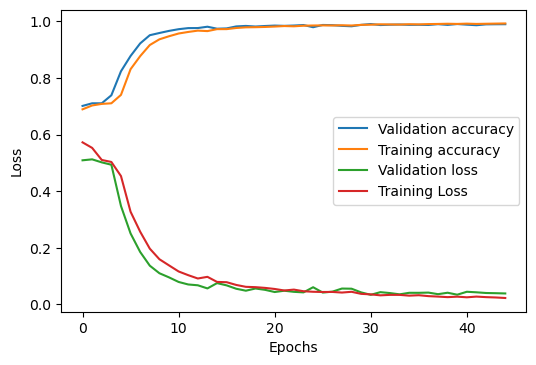

238/238 [==============================] - 24s 88ms/step - loss: 0.0318 - accuracy: 0.9895
loss:  0.031736329197883606 accuracy:  0.9898066520690918
Test accuracy: 98.98%


In [7]:
model = A2.load_model(path, plot=True)
A2.model_eval(model, x_test, y_test)

# Prediction

In [8]:
prediction = model.predict(x_test, verbose=1)

238/238 [==============================] - 22s 83ms/step


Ground-truth: [0 1 0 0 0 0 1 0]
Predictions : [0 1 0 0 0 0 1 0]


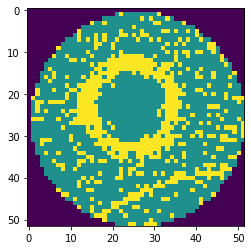

Predictions : Donut, Scratch, 


In [19]:
pred_img_num = 900
image = np.squeeze(x_test[pred_img_num,:,:,0])
#print("Model output:", (prediction[pred_img_num,:]))
print("Ground-truth:", np.array(y_test[pred_img_num,:]))
print("Predictions : [" + " ".join(["{:.0f}".format(val) for val in prediction[pred_img_num]]) + "]")

plt.imshow(image)
plt.show()

label = np.array(["{:.0f}".format(val) for val in prediction[pred_img_num]]).astype(float)
print("Predictions :", A1.read_label(label))

Ground-truth: [0 1 1 0 1 0 1 0]
Predictions : [0 1 1 0 1 0 1 0]


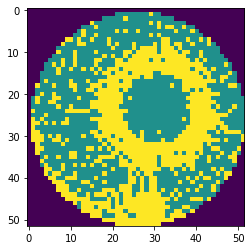

Predictions : Donut, Edge_Loc, Loc, Scratch, 


In [25]:
pred_img_num = 500
image = np.squeeze(x_test[pred_img_num,:,:,0])
#print("Model output:", (prediction[pred_img_num,:]))
print("Ground-truth:", np.array(y_test[pred_img_num,:]))
print("Predictions : [" + " ".join(["{:.0f}".format(val) for val in prediction[pred_img_num]]) + "]")

plt.imshow(image)
plt.show()

label = np.array(["{:.0f}".format(val) for val in prediction[pred_img_num]]).astype(float)
print("Predictions :", A1.read_label(label))

Ground-truth: [1 0 0 0 1 0 1 0]
Predictions : [1 0 0 0 1 0 1 0]


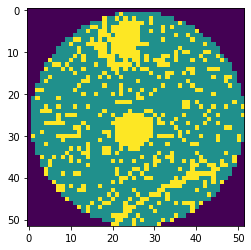

Predictions : Center, Loc, Scratch, 


In [28]:
pred_img_num = 3000
image = np.squeeze(x_test[pred_img_num,:,:,0])
#print("Model output:", (prediction[pred_img_num,:]))
print("Ground-truth:", np.array(y_test[pred_img_num,:]))
print("Predictions : [" + " ".join(["{:.0f}".format(val) for val in prediction[pred_img_num]]) + "]")

plt.imshow(image)
plt.show()

label = np.array(["{:.0f}".format(val) for val in prediction[pred_img_num]]).astype(float)
print("Predictions :", A1.read_label(label))